# Formalia:

Please read the [assignment overview page](https://github.com/lalessan/comsocsci2022/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday, April 5th at 23:55. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Course Content, Assignemnts, Assignment 2)_


Remember to include in the first cell of your notebook:
* the link to your group's Git repository
* group members' contributions

#### Link to Github repository: 
https://github.com/almafaz/CSSAssignments

The work was distributed equally among all group members.

# Computational Social Science 2022 - Assignment 2
#### by Alma Fazlagic (s194271), Natasha Norsker (s194270) & Simone von Mehren (s190739)

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
import re
stopword_vocab = stopwords.words('english')
ps = PorterStemmer()


from collections import Counter
import itertools
from operator import itemgetter


from wordcloud import WordCloud
import shifterator as sh
import matplotlib.pyplot as plt

## Part 1: TF-IDF

For this exercise, you need the following data: 
* The r/wallstreetbets submissions (either the one provided by me [here](https://github.com/lalessan/comsocsci2021/blob/master/data/wallstreet_subs.csv.gz) or the one you downloaded in Week 6).
* The list of 15 stocks you identified in Week 6, Exercise 2.

_Exercise_


> 1. Tokenize the __text__ of each submission. Create a column __tokens__ in your dataframe containing the tokens. Remember to follow the instructions in Week 6, Exercise 3.  
> 2. Find submissions discussing at least one of the top 15 stocks you identified above (follow the instructions in Week 6, Exercise 3).

To get the list of the top 15 stocks from the wallstreet submissions, we apply the "find_ticker" function created in week 6.

In [2]:
submissions_p1 = pd.read_csv("Assignment2_files/wallstreet_subs.csv")
submissions_p1["text"] = submissions_p1.title + " " + submissions_p1.selftext

In [3]:
def find_ticker(text):
    regex = "\$[a-zA-Z]+"
    found_tickers = re.findall(regex,text)
    
    return [tick[1:].upper() for tick in found_tickers]

In [4]:
# apply the function
submissions_p1["tickers"] = submissions_p1.text.apply(find_ticker)

In [5]:
#get all tickers from the dataframe and unlist them:
all_tickers = list(itertools.chain(*submissions_p1.tickers.values))

#use nltk to find the top 15 ticker symbols
fd = nltk.FreqDist(all_tickers)
fd.most_common(15)

[('SPY', 1150),
 ('TSLA', 988),
 ('SPCE', 562),
 ('PLTR', 394),
 ('MSFT', 377),
 ('ROPE', 359),
 ('AAPL', 243),
 ('AMZN', 230),
 ('NIO', 228),
 ('ZM', 227),
 ('AMD', 212),
 ('BABA', 207),
 ('GME', 202),
 ('DIS', 169),
 ('BA', 164)]

We can see that the top 15 mentioned stocks (/ticker symbols) include known companies such as Apple, Gamestop, Tesla, Amazon, Disney, Boeing, etc. Other stocks are unfamiliar to us such as Alibaba Group (a Chinese multinational conglomerate holding-company) and Palantir Technologies Inc. (an American software company). Furthermore we see that the ticker symbol ROPE is included in the top 15 even though ROPE is not actually a stock, but a meme which is used to express that someone has lost a lot of money on stocks. This example indicates that our method is not perfect and one should be aware of possible flaws like this, when analysing the data.

Next we tokenize the submissions and filter the tokens using the stopword vocabulary and the Porter stemmer from nltk:

In [6]:
def tokenize_text(text):
    filtered = [ps.stem(w.lower()) for w in word_tokenize(text) 
                if w.isalpha() and w.lower() not in stopword_vocab]
    return filtered

In [7]:
# apply the tokenize function (takes a little while)
submissions_p1["tokens"] = submissions_p1.text.apply(tokenize_text)

In [8]:
#the tokens also get stemmed when we apply the tokens, so we stem the top15 list as well
top_15 = [ps.stem(w) for w,_ in fd.most_common(15)]

In [9]:
def find_stock(tokens):
    found_stocks = [token.upper() for token in tokens if token in top_15]
    return found_stocks

# apply the find stock function and explode
submissions_p1["stock"] = submissions_p1.tokens.apply(find_stock)
submissions_p1 = submissions_p1.explode('stock')
submissions_p1.stock = submissions_p1.stock.fillna('Other')

In [10]:
fd2 = nltk.FreqDist(submissions_p1.stock.values)
fd2.most_common(15)

[('Other', 58268),
 ('SPI', 14648),
 ('TSLA', 8371),
 ('PLTR', 6654),
 ('NIO', 3788),
 ('GME', 3586),
 ('AMD', 3442),
 ('MSFT', 2644),
 ('SPCE', 2638),
 ('AAPL', 2356),
 ('AMZN', 1600),
 ('BABA', 1143),
 ('DI', 988),
 ('ZM', 918),
 ('BA', 836)]

> 3. Now, we want to find out which words are important for each *stock*, so we're going to create several ***large documents, one for each stock***. Each document includes all the tokens related to the same stock. We will also have a document including discussions that do not relate to the top 15 stocks.


In [11]:
def large_document(stock):
    stock_list = submissions_p1.loc[submissions_p1['stock'] == stock].tokens.tolist()
    stock_list = list(itertools.chain(*stock_list))
    stock_list = list(filter(lambda val: (val !=  "https") & (val != "http"), stock_list))
    return stock_list

We use the large_document-function to create large documents for each of the five stocks, which we will investigate further below. This could be done in the exact same way for the remaining 10 stocks in top 15, but we do not use these documents for any further investigation and the creation of these is therefore omitted to reduce computations. 

We choose to investigate the stocks Gamestop (GME), Amazon (AMZN), Apple (AAPL), Alibaba Group (BABA) and Microsoft (MSFT) further:

In [12]:
GME_doc = large_document("GME")
GME_fd = nltk.FreqDist(GME_doc)

AMZN_doc = large_document("AMZN")
AMZN_fd = nltk.FreqDist(AMZN_doc)

AAPL_doc = large_document("AAPL")
AAPL_fd = nltk.FreqDist(AAPL_doc)

BABA_doc = large_document("BABA")
BABA_fd = nltk.FreqDist(BABA_doc)

MSFT_doc = large_document("MSFT")
MSFT_fd = nltk.FreqDist(MSFT_doc)


> 4. Now, we're ready to calculate the TF for each word. Find the top 5 terms within __5 stocks of your choice__. 
>   * Describe similarities and differences between the stocks.
>   * Why aren't the TFs not necessarily a good description of the stocks?
>   * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?

The term frequency (TF) is computed using the following formular:
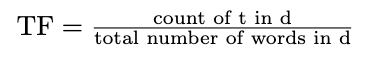
where t is the term and d denotes the document.

In [13]:
def computeTF(doc):
    TF_dict = dict([(key, round(value/len(doc),6)) for key,value in Counter(doc).items()])
    return TF_dict    

In [14]:
# Compute TF for each word in the large documents of the five chosen stocks
GME_TF = computeTF(GME_doc)
AMZN_TF = computeTF(AMZN_doc)
AAPL_TF = computeTF(AAPL_doc)
BABA_TF = computeTF(BABA_doc)
MSFT_TF = computeTF(MSFT_doc)

In [15]:
five_stocks = ["GME", "AMZN", "AAPL", "BABA", "MSFT"]
five_stocks_tf =  [GME_TF, AMZN_TF,AAPL_TF,BABA_TF,MSFT_TF]

for stock, stock_tf in zip(five_stocks, five_stocks_tf):
    print("Top 5 terms for", stock)
    print(sorted(stock_tf.items(),key= lambda x:x[1], reverse=True)[:5], "\n")

Top 5 terms for GME
[('gme', 0.029603), ('short', 0.013428), ('amp', 0.010851), ('share', 0.00944), ('go', 0.007917)] 

Top 5 terms for AMZN
[('amp', 0.017104), ('amzn', 0.01515), ('earn', 0.009703), ('gt', 0.00943), ('tsla', 0.008286)] 

Top 5 terms for AAPL
[('aapl', 0.019341), ('amp', 0.017915), ('gt', 0.012403), ('stock', 0.010163), ('earn', 0.009324)] 

Top 5 terms for BABA
[('baba', 0.031461), ('compani', 0.011891), ('amp', 0.010293), ('chines', 0.009433), ('market', 0.008873)] 

Top 5 terms for MSFT
[('msft', 0.022326), ('spi', 0.015424), ('amp', 0.015008), ('call', 0.011957), ('option', 0.009935)] 



One of the similarities between all stocks is that the name of the stock (ticker symbol) itself is among the top 2 mentioned terms of the stock. This seems reasonable as this is, indeed, what is discussed in the submission. 

Furthermore the term (more precisely the stem of the word) "amp" is recurring in the top 5 for all of the five stocks. In order to analyse the meaning of this stem in all top5's, we have to look at the original submissions including this term before stemming. This reveals that the term "amp" has several meanings and use cases in the submission dataset, First of all it is an acronym for "Auction Preferred Stock", and secondly it is used in the XML Escape value for coding a zero-width white space. All in all this term is not informative at all to us as it appears in all of the top 5's.

In multiple of the top 5's, other stock names is mentioned as well. For example in the MSFT top 5 where SPY (stem is SPI) is mentioned, and in the AMZN top 5 where TSLA is mentioned as well. The remaining words in each of the top 5's differ from each other, although they are mostly very common terms within the financial world such as "market", "option", "short", "share", "compani", and "call". 

Conclusively, the review of top 5 TF words for each of the five stocks, gives us a rather good indication of, why TFs are not necessarily a good description of the individual stocks. The TF formular gives us the terms, which occur most often in a document. However, this is not necessarily a good indicator of, how relevant a term is for a document, as the most occuring words will often be very common words (even though we remove stop words beforehand). This is exactly what we see in these top 5 TFs as well, where very common financial terms are included in the top 5's.

In [16]:
# Create corpora including the five chosen large documents
five_stocks_docs = [GME_doc, AMZN_doc, AAPL_doc, BABA_doc, MSFT_doc]
corpora = {}

for i in range(len(five_stocks_docs)):
    corpora[i] = five_stocks_docs[i]

The IDF formula is as follows:
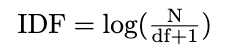
where N is the total number of documents, df is the document frequency (number of documents in which term t occurs) and 1 is the shrink term.

Usually it is smart to add a shrink term to the denominator (+1 for example) to avoid division by zero.

However, in our case we are certain that all terms is present at least once in one of the documents and therefore we can omit the shrink term (which in return ensures no negative IDF values). Our final IDF formula used in the assignment is therefore the following:
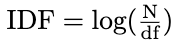

In [17]:
# We only want the unique words in our IDF corpora:
corpora_list = []
for i in range(len(corpora)):
    corpora_list.append(corpora[i])


corpora_set = set([term for sublist in corpora_list for term in sublist])

# Compute IDF for all terms in the five large documents

IDFs = {}
N = len(corpora)
for term in corpora_set:
    # compute document frequency for each term:
    counter = 0
    for i in range(len(corpora)):
        if term in set(corpora[i]):
            counter += 1
    # Compute IDF for term
    IDFs[term] = np.log(N / counter)

When computing the IDF values, we use the natural logarithm base, e. We choose this base, as we work with very small percentage changes in our data (a very small range of data) and the natural logarithm is a good choice for representing this kind of data. Choosing another logarithmic base would not be entirely wrong, but it would chance the scale at which our IDF values lie. 

> 5. We're ready to calculate TF-IDF. Do that for the __5 stock of your choice__. 
>   * List the 10 top TF words for each stock.
>  * List the 10 top TF-IDF words for each stock.
>   * Are these 10 words more descriptive of the stock? If yes, what is it about IDF that makes the words more informative?

The formular for calculating TF-IDF values is the following:
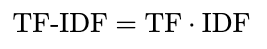

In [18]:
# Create function for computing TF-IDF values
def computeTF_IDF(TF_dict, IDF_dict):
    IDF_dict_stock = {}
    for key, val in TF_dict.items():
        tf = val
        idf = IDF_dict[key]
        IDF_dict_stock[key] = round(tf*idf, 6)
    
    return IDF_dict_stock

In [19]:
# Compute TF-IDF for the five chosen stocks
GME_TF_IDF = computeTF_IDF(GME_TF, IDFs)
AMZN_TF_IDF = computeTF_IDF(AMZN_TF, IDFs)
AAPL_TF_IDF = computeTF_IDF(AAPL_TF, IDFs)
BABA_TF_IDF = computeTF_IDF(BABA_TF, IDFs)
MSFT_TF_IDF = computeTF_IDF(MSFT_TF, IDFs)

five_stocks_tf_idf = [GME_TF_IDF, AMZN_TF_IDF, AAPL_TF_IDF, BABA_TF_IDF, MSFT_TF_IDF]

In [20]:
# 10 top TF words and 10 top TF-IDF words for each stock
for stock, stock_tf, stock_tf_idf  in zip(five_stocks, five_stocks_tf, five_stocks_tf_idf):
    print("10 top TF words for", stock)
    print(sorted(stock_tf.items(),key= lambda x:x[1], reverse=True)[:10], "\n")
    
    print("10 top TF-IDF words for", stock)
    print(sorted(stock_tf_idf.items(), key= lambda x:x[1], reverse=True)[:10], "\n")

10 top TF words for GME
[('gme', 0.029603), ('short', 0.013428), ('amp', 0.010851), ('share', 0.00944), ('go', 0.007917), ('like', 0.007676), ('buy', 0.00706), ('long', 0.006956), ('gamestop', 0.006247), ('squeez', 0.00624)] 

10 top TF-IDF words for GME
[('cohen', 0.001367), ('sherman', 0.000818), ('consol', 0.000619), ('olshan', 0.000602), ('hestia', 0.000467), ('ciccio', 0.000447), ('idiom', 0.000401), ('mel', 0.000373), ('moass', 0.000312), ('dopierala', 0.000307)] 

10 top TF words for AMZN
[('amp', 0.017104), ('amzn', 0.01515), ('earn', 0.009703), ('gt', 0.00943), ('tsla', 0.008286), ('stock', 0.007848), ('gain', 0.007625), ('loss', 0.007423), ('spi', 0.007137), ('market', 0.006758)] 

10 top TF-IDF words for AMZN
[('ua', 0.00033), ('speedrun', 0.000172), ('tesl', 0.000172), ('winningest', 0.000172), ('losingest', 0.000172), ('blowup', 0.000166), ('holid', 0.000162), ('adj', 0.00016), ('ant', 0.000152), ('ccp', 0.00013)] 

10 top TF words for AAPL
[('aapl', 0.019341), ('amp', 0.0

In the cell above, we have displayed the top 10 TF words and top 10 TF-IDF words for each of the stocks, respectively. We already inspected the top 5 TF words for each stock earlier in the assignment and now we will compare the TF words with the TF-IDF words.

The top 10 TF-IDF words definitely seems more descriptive of the individual stocks, as there are almost no recurring terms between the top 10 lists now. This indicates that terms with high TF-IDF values are more relevant for the specific document i.e. stock. The IDF values adds a measure of informativeness of each term which the TF values lack. That is, the most occurring words across all documents will have very low IDF value, whereas very rare words across documents will have very high IDF values. In the extreme case where a word is present in all documents, the IDF value will be zero, as this gives us no new information about the individual documents. 

Combining the TF and IDF value therefore gives us a relative weightage of number of occurrences of a word and the uniqueness of the word across documents. 

> 6. Visualize the results in a Wordcloud and comment your results (follow the instrutions in Week 6, Exercise 4). 



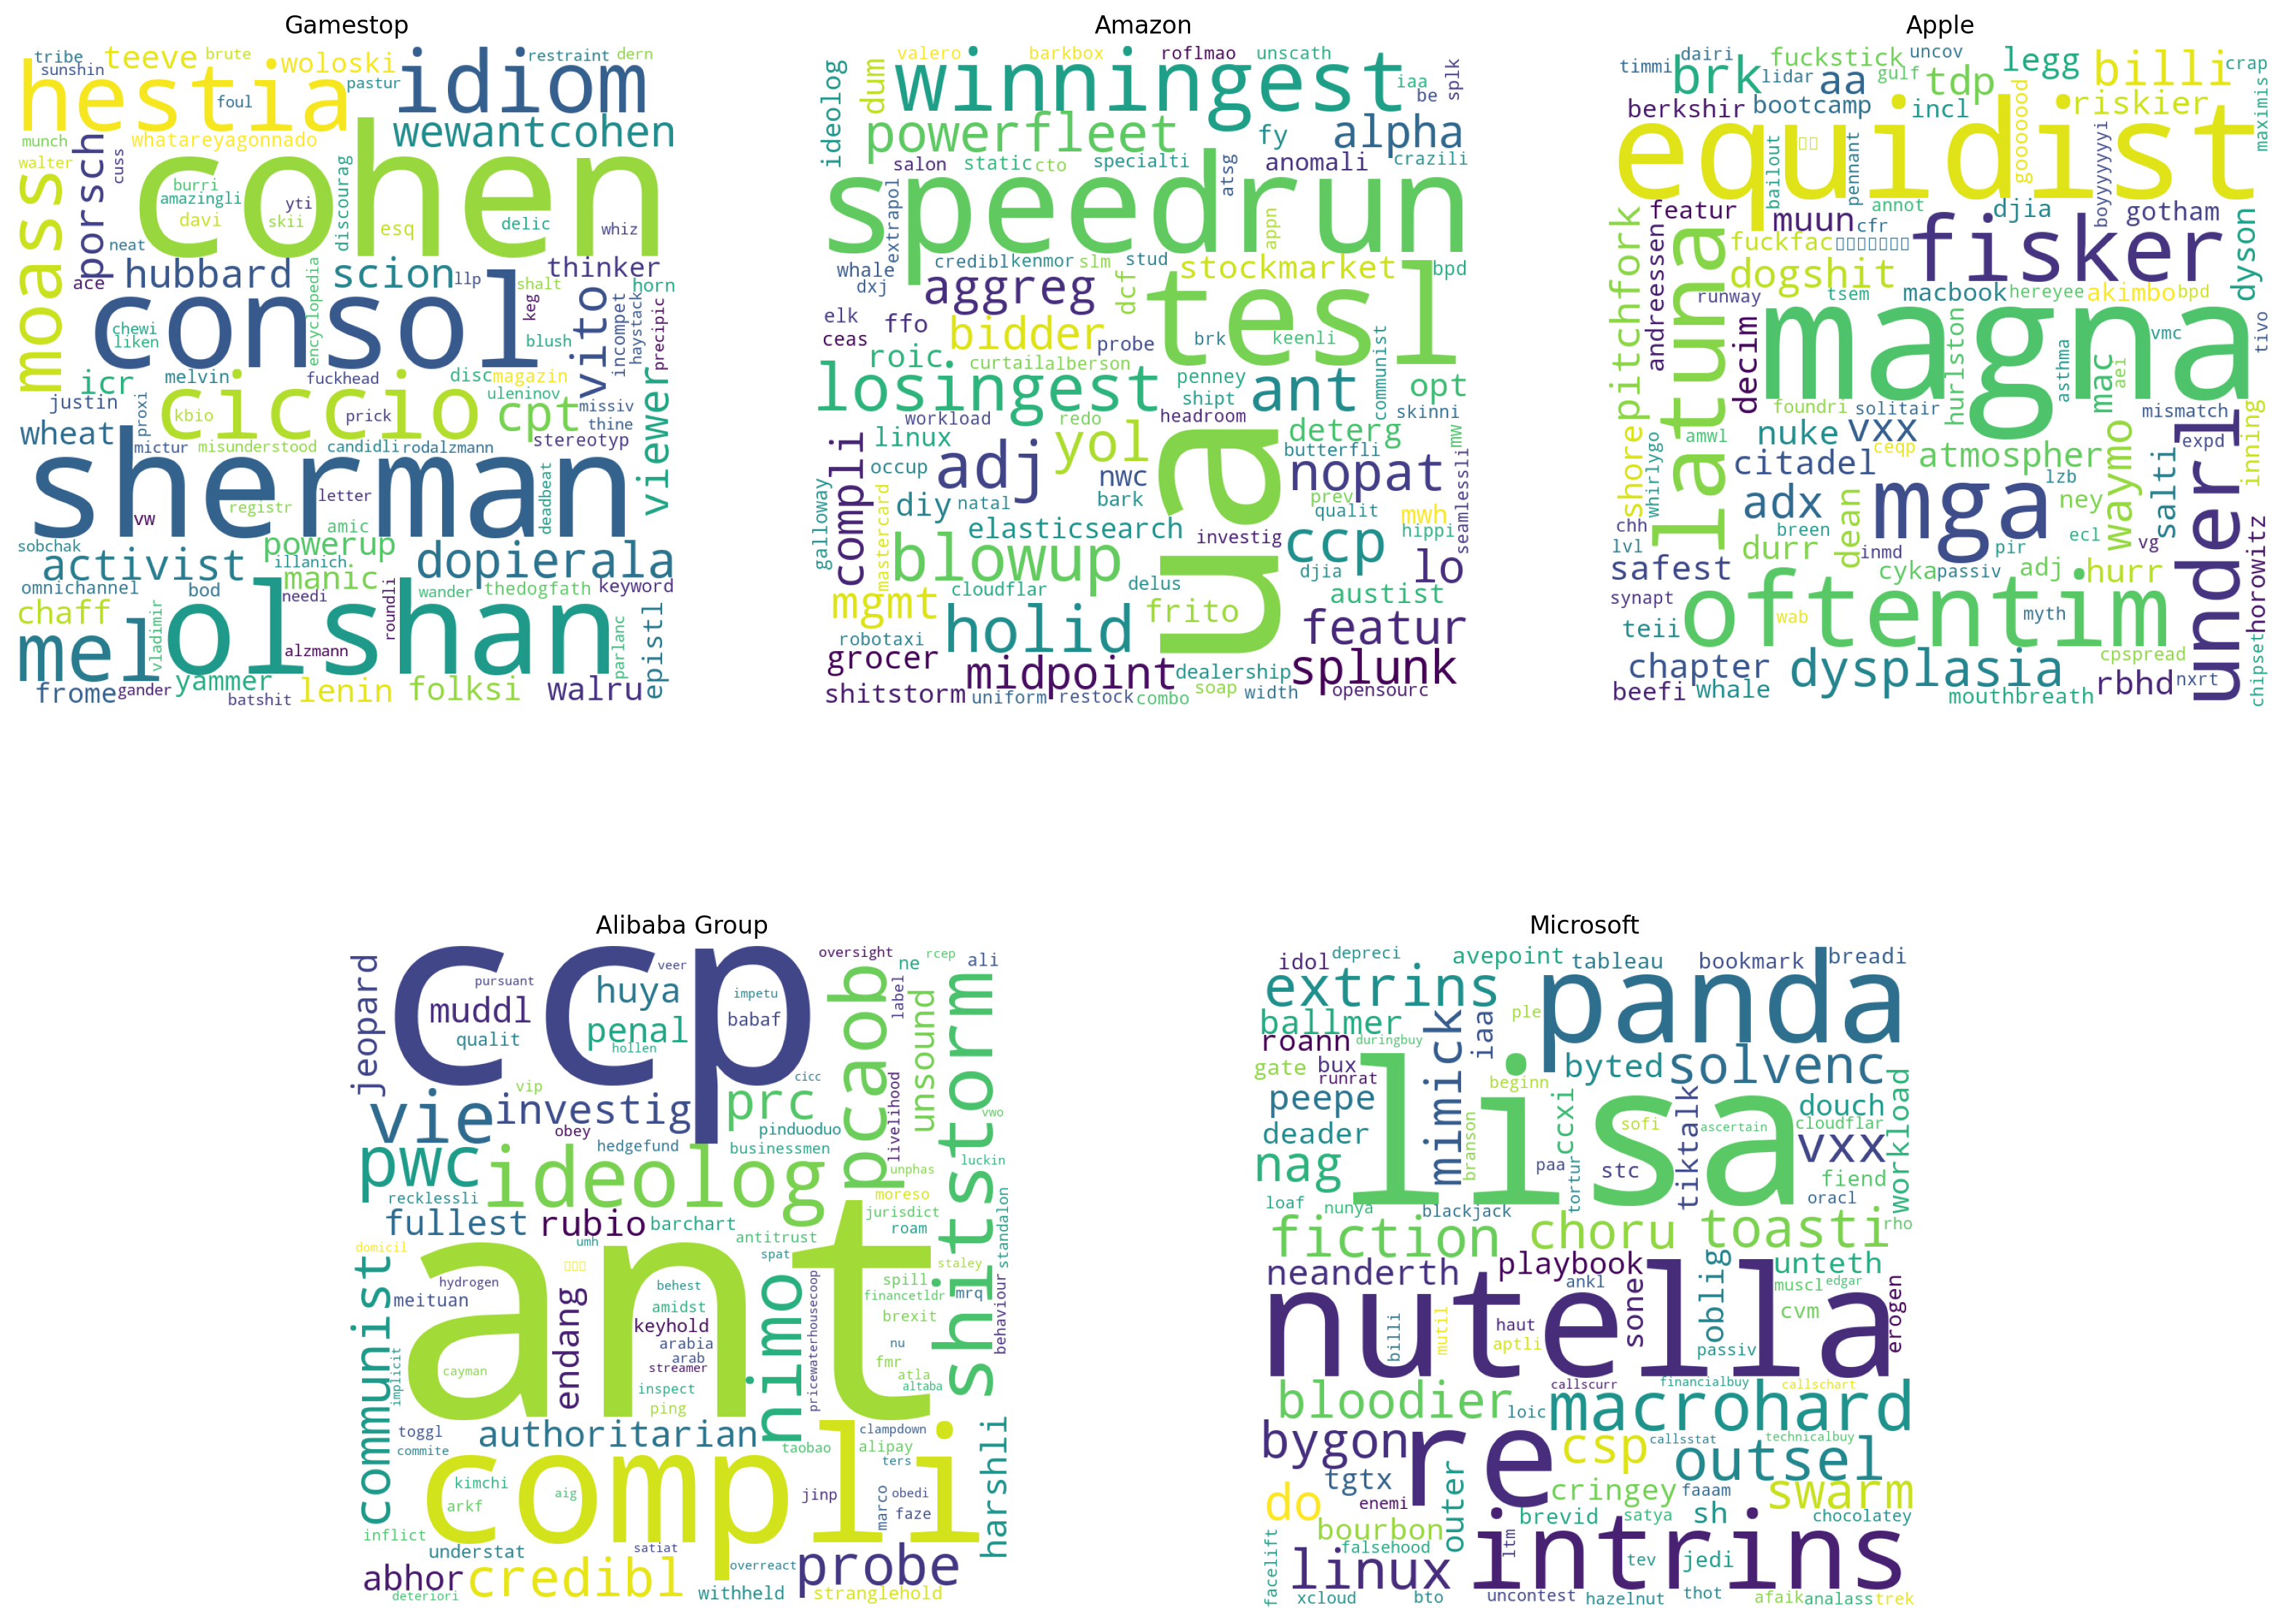

In [40]:
# Creating wordclouds for each stock

wordcloud_GME = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                max_words=100).generate_from_frequencies(GME_TF_IDF)

wordcloud_AMZN = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                max_words=100).generate_from_frequencies(AMZN_TF_IDF)

wordcloud_AAPL = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                max_words=100).generate_from_frequencies(AAPL_TF_IDF)

wordcloud_BABA = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                max_words=100).generate_from_frequencies(BABA_TF_IDF)

wordcloud_MSFT = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                max_words=100).generate_from_frequencies(MSFT_TF_IDF)


# Plot the word clouds
fig, axes = plt.subplots(2,3, dpi=200, figsize=(20,15))
axes[1][2].set_visible(False)

axes[1][0].set_position([0.24,0.125,0.228,0.343])
axes[1][1].set_position([0.55,0.125,0.228,0.343])

axes[0][0].imshow(wordcloud_GME)
axes[0][0].axis("off")
axes[0][0].title.set_text('Gamestop')

axes[0][1].imshow(wordcloud_AMZN)
axes[0][1].axis("off")
axes[0][1].title.set_text('Amazon')

axes[0][2].imshow(wordcloud_AAPL)
axes[0][2].axis("off")
axes[0][2].title.set_text('Apple')

axes[1][0].imshow(wordcloud_BABA)
axes[1][0].axis("off")
axes[1][0].title.set_text('Alibaba Group')

axes[1][1].imshow(wordcloud_MSFT)
axes[1][1].axis("off")
axes[1][1].title.set_text('Microsoft')

In the figure above a wordcloud for each of the five stocks can be seen. The wordclouds have been generated based on the TF-IDF scores for the top words related to each stock. In other words, the words with the top 100 TF-iDF scores have been included in each wordcloud.

The wordclouds are a nicer and more comprehensible way to present the words with high TF-IDF scores, as they clearly illustrate the most relevant words by using a larger font size for these words. Looking at the different wordclouds, some interesting things about the Reddit Wallstreet debates regarding the different stocks can be inferred. For example the words "Lisa" and "Nutella" have some of the highest TF-IDF scores for the Microsoft (MSFT) score. "Nutella" is in fact a nickname for the CEO of Microsoft, Satya Nadella, and Lisa is the first name of Lisa Su, CEO of AMD, who co-operated with Microsoft to develop AMD processors for the Microsoft products. 

In the same way we can infer interesting things about the subjects being discussed in relation to the other stocks fx Gamestop. "Cohen" and "Sherman" are rated some of the most relevant words in the Gamestop debate. "Cohen" is the last name of Gamestop Chairman Ryan Cohen, who had an immense impact on the stock surge, when he bought tens of millions of dollars worth of shares in Gamestop. In the same way, "Sherman" refers to the former CEO of Gamestop, George Sherman.

Conclusively, the TF-IDF wordclouds provides a nice and clear representation of the most relevant words and the wor

## Part 2: Sentiment analysis

_Exercise: Creating Word Shifts_
>    1. Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).
>    2. Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively. 
>    3. For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.
>    4. For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?
>    5. Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 
>    6. Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).
>    7. Now install the [``shifterator``](https://shifterator.readthedocs.io/en/latest/installation.html) Python package. We will use it for plotting Word Shifts. 
>    8. Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. Comment on the figure. 
>    9. How do words that you printed in step 6 relate to those shown by the WordShift? 

In [22]:
# first we download the happiness data...
labMT_data = pd.read_csv("Assignment2_files/Hedonometer.csv")

In [23]:
lab_dict = dict(zip(labMT_data.Word, labMT_data["Happiness Score"]))

def get_avg_score(doc):
    available_words = [w for w in doc if w in lab_dict.keys()]
    word_frequencies = nltk.FreqDist(available_words)
    total_frequency = len(available_words)
    
    total = 0
    
    for word, weight in word_frequencies.items():
        total += lab_dict[word] * weight
    
    return round(total/total_frequency,4)

In [24]:
submissions_p2 = pd.read_csv("Assignment2_files/wallstreet_subs.csv")
submissions_p2["text"] = submissions_p2.title + " " + submissions_p2.selftext
submissions_p2["date"]=submissions_p2["created_utc"].apply(lambda x: dt.datetime.utcfromtimestamp(x)).dt.date
submissions_p2["date"] = pd.to_datetime(submissions_p2['date'])

In [25]:
#we do not stem this time
def tokenize_text(text):
    filtered = [w.lower() for w in word_tokenize(text) if w.isalpha() and w.lower() not in stopword_vocab]
    return filtered

In [26]:
# apply the tokenize function
submissions_p2["tokens"] = submissions_p2.text.apply(tokenize_text)

In [27]:
documents = pd.DataFrame({"date": submissions_p2["date"],
                         "tokens": submissions_p2.tokens})
documents = documents.groupby('date').agg(sum)
documents["length"] = documents.tokens.apply(len)

In [28]:
documents["avg_score"] = documents.tokens.apply(get_avg_score)

In [29]:
min_h = documents.avg_score.min()
d = documents[documents.avg_score == min_h].index[0]
d_min = d-dt.timedelta(days=7)

print(d)

2020-03-08 00:00:00


In [30]:
l = documents.tokens[d]
l_ref = np.concatenate(documents[(documents.index < d) 
          & (documents.index > d_min)].tokens.values)

In [31]:
p = dict([(key, value/len(l)) for key,value in Counter(l).items()])
p_ref = dict([(key, value/len(l_ref)) for key,value in Counter(l_ref).items()])

all_tokens = set(p.keys()).union(set(p_ref.keys()))
dp = dict([(token,p.get(token,0) - p_ref.get(token,0)) for token in all_tokens])

In [32]:
sorted(dp.items(),key= lambda x:x[1], reverse=True)[:10]

[('people', 0.0025448830392282035),
 ('oil', 0.0022820045330659757),
 ('virus', 0.0017803673739761345),
 ('opk', 0.001627293688458667),
 ('put', 0.0015823819183125322),
 ('buy', 0.001554327289870042),
 ('companies', 0.0015221545821663001),
 ('term', 0.001477344141590044),
 ('uk', 0.0013229520331296597),
 ('high', 0.001291347454137935)]

In [33]:
h = dict([(token,lab_dict.get(token,np.nan)-5) for token in all_tokens])
dPhi = dict([(token, h[token] * dp[token]) for token in all_tokens if not np.isnan(h[token])])

In [34]:
sorted(dPhi.items(),key= lambda x:np.abs(x[1]), reverse=True)[:10]

[('earnings', -0.005409635112742592),
 ('virus', -0.005198672732010312),
 ('google', -0.003501947202525911),
 ('today', -0.00317927363899376),
 ('flu', -0.0030818209156879073),
 ('million', 0.0030316936328827),
 ('people', 0.0029520643255047164),
 ('deaths', -0.0022412009597016923),
 ('debt', -0.0022406386147449),
 ('high', 0.002117809824786213)]

/Users/simonevonmehren/Library/Python/3.8/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


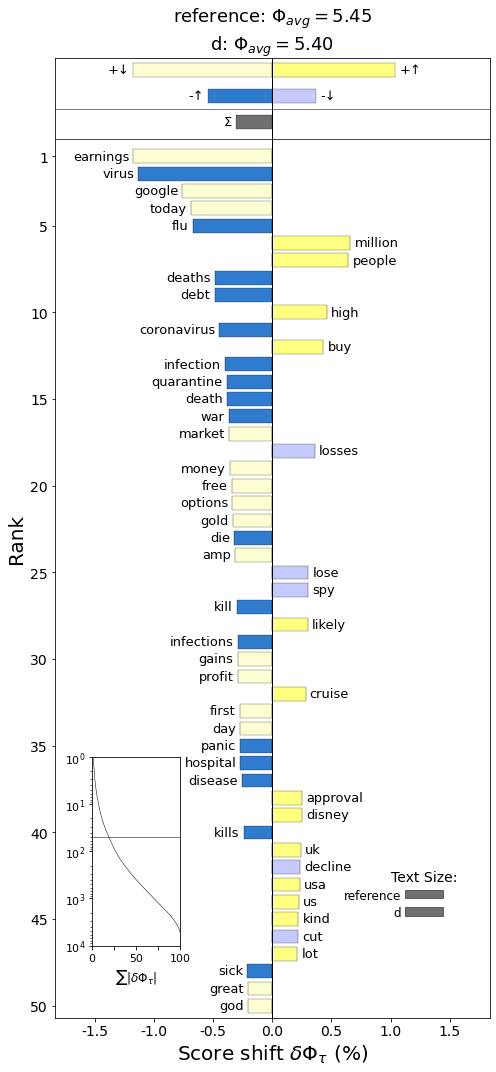

In [35]:
sentiment_shift = sh.WeightedAvgShift(type2freq_1 = p_ref,
                     type2freq_2 = p,
                       type2score_1 = lab_dict,
                   reference_value =5)


sentiment_shift.get_shift_graph(detailed=True,
                               system_names = ["reference","d"])
plt.show()

## Part 3: Communities for the Zachary Karate Club Network

_Exercise: Zachary's karate club_: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable/auto_examples/graph/plot_karate_club.html).

> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
>
> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.
> 3. Explain in your own words the concept of _modularity_. 
> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.
> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement a [configuration model](https://en.wikipedia.org/wiki/Configuration_model). In short, we will create a new network, such that each node has the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network. 
>       * __b.__ Consider the list of network edges. Create two lists: the list of source nodes and target nodes. (e.g. edges = [(1,2),(3,4)], sources = [1,3], targets = [2,4])
>       * __c.__ Concatenate the list of source nodes and target nodes into a unique list (e.g. [1,3,2,4]). This is the list of _stubs_ (see the [Wikipedia page](https://en.wikipedia.org/wiki/Configuration_model) for the definition of stub).
>       * __d.__ Shuffle the list of stubs. Build a set of edges (tuples), by connecting each element in the list of shuffled stubs with the following element. (e.g. [4,1,2,3] --> [(4,1),(2,3)])
>       * __e.__ Remove all the original network edges from your network. Add all the new _shuffled_ edges you created in step __d.__
> 6. Is the degree of the nodes in your original and the configuration model network the same? Why? __Note 1:__ With this algorithm you may obtain some self-loops. Note that [a self-loop should add two to the degree](https://en.wikipedia.org/wiki/Loop_(graph_theory%29#:~:text=For%20an%20undirected%20graph%2C%20the,adds%20two%20to%20the%20degree.&text=In%20other%20words%2C%20a%20vertex,not%20one%2C%20to%20the%20degree.). __Note 2:__ With this algorithm, you could also obtain repeated edges between the same two nodes. Only NetworkX [MultiGraph](https://networkx.org/documentation/stable/reference/classes/multigraph.html) allow for repeated edges, while regular [Graph](https://networkx.org/documentation/stable/reference/classes/graph.html?highlight=graph%20undirected#networkx.Graph) do not, meaning you will not be able to account for multi-edges when you have a regular Graph. (_Optional_: if you want to implement a configuration model without self-loops and multi-edges, you can try out the [double_edge_swap](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html) algorithm)
> 7. Create $1000$ randomized version of the Karate Club network using the algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.
> 8. Compute the average and standard deviation of the modularity for the configuration model.
> 9. Plot the distribution of the configuration model modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 
> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to compare with the configuration model? What is the reason why we preserved the nodes degree?
> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?
> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

_Exercise: Community detection on the GME network._
> * Consider the GME network you built in [Week 4](https://github.com/lalessan/comsocsci2022/blob/main/lectures/Week4.ipynb), part 2.
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * Visualize the network, using netwulf (see Week 4). This time assign each node a different color based on their _community_. Describe the structure you observe.